# **Figure 11.** Dust Motions
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 01/31/2022          |
| Updated | 08/18/2023          |

## $D_\mathrm{p}$, $H_\mathrm{p}$ vs. $\Pi$
See Yang et al. (2009), § 4.1, for CC's derivation of the diffusion coefficient, $D_\mathrm{p}$.

From Eq. 9 of Yang & Zhu (2021),
\begin{equation}
  H_\mathrm{p} \approx \sqrt{\frac{D_{\mathrm{p}_z}}{\Omega_\mathrm{K}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)} = H_\mathrm{g}\sqrt{\frac{D_{\mathrm{p}_z}}{c_\mathrm{s}H_\mathrm{g}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)},
\end{equation}
where $(\tau_\mathrm{s} + \tau_\mathrm{s}^{-1})/\Omega_\mathrm{K}$ is the sedimentation time-scale (Youdin & Lithwick 2007).

### Units

Our *length* $[\sf{L}]$ and *time* $[\sf{T}]$ [code units](https://github.com/sabaronett/streaming-instability/blob/main/ipynb/ref/CodeUnits.ipynb) in Athena++ are the vertical gas scale height $H = c_\mathrm{s}/\Omega = 1$ and orbital period $T = 2\pi/\Omega = 1$, respectively.
Accordingly, we set the speed of sound and angular frequency of our shearing box as $ c_\mathrm{s} = \Omega = 2\pi$ in our Athena++ input file `athinput.si`.
With these, we can convert the diffusion coefficient's $D [H^2/T]$ units that we measure natively to more standard $[c_\mathrm{s}H]$ units as follows:
\begin{align*}
    \frac{D}{H^2/T} = \frac{D}{H}\frac{T}{H} &= \frac{D}{H}\frac{2\pi}{\Omega}\frac{\Omega}{c_\mathrm{s}} = \frac{D}{H}\frac{2\pi}{c_\mathrm{s}} \\
    \frac{D}{c_\mathrm{s}H} &= \frac{1}{2\pi}\frac{D}{H^2/T}
\end{align*}

AB (Π = 0.05):
    Hp = 0.015Hg
  Zeff = 0.015
BA (Π = 0.05):
    Hp = 0.151Hg
  Zeff = 0.030


,Case,a,a_f.e.,k,k_f.e.
0,AB,0.234,± 11%,0.902,± 3%
1,BA,0.170,± 67%,0.078,± 241%


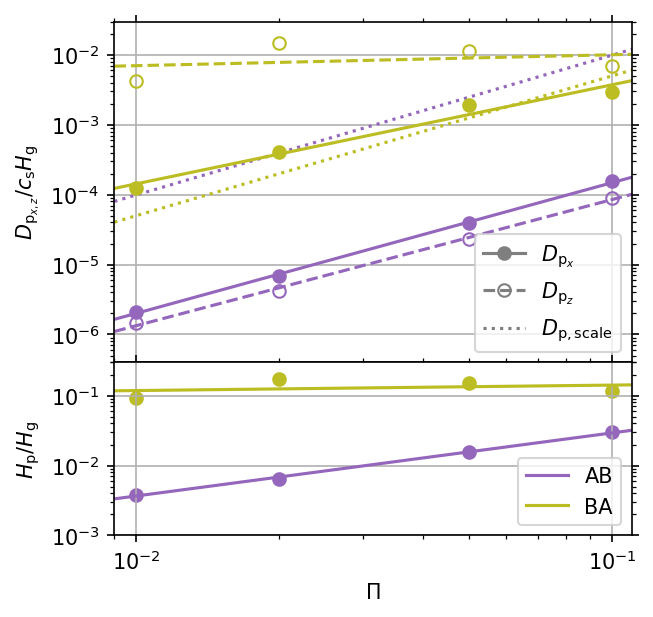

In [1]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

D_ylim, Hp_ylim = (4e-7, 3e-2), (1e-3, 3e-1)
D_ydiff = np.log10(D_ylim[1]) - np.log10(D_ylim[0])
Hp_ydiff = np.log10(Hp_ylim[1]) - np.log10(Hp_ylim[0])
h_ratio = D_ydiff/Hp_ydiff
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.45, 4.45), dpi=150,
                        height_ratios=[h_ratio, 1])
workdir = '../unstrat'
cases = [['AB', 'tab:purple', 1.0], ['BA', 'tab:olive', 0.2]]
Pis = [0.01, 0.02, 0.05, 0.1]
res = '2048'
dirs = [['x', 'dpx', 'full', 'solid'],
        ['z', 'dpy', 'none', 'dashed']]
pow_law = lambda Pi, a, k : a*Pi**k
lin_fit = lambda x, b, m : m*x + b
xs = np.linspace(0.009, 0.2)

# Diffusion coefficient variables
Ds = np.zeros((len(Pis), len(dirs)))
logDs = np.zeros((len(Pis), len(dirs)))
D_runs, tdirs = [], []
D_as, D_a_ferrs = [], []
D_ks, D_k_ferrs = [], []

# Particle scale height variables
Hps = np.zeros(len(Pis))
logHps = np.zeros(len(Pis))
Hp = lambda Dz, tau_s: np.sqrt(Dz*(tau_s + 1/tau_s))
Hp_cases = []
Hp_as, Hp_a_ferrs = [], []
Hp_ks, Hp_k_ferrs = [], []

for case in cases:
    axs[1].plot([], [], color=case[1], label=case[0])

    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            # Collect sim parameters, diffusion coefficients, dust scale heights
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            c_s = athinput['hydro']['iso_sound_speed']
            Omega = athinput['problem']['omega']
            Hg = c_s/Omega
            tau_s = athinput['particles']['taus0']*Omega
            npz = np.load(f'{path}/npz/dcoeff.npz')
            Ds[j, i] = npz[dir[1]][0]/c_s                 # convert to [c_s*Hg]
            logDs[j, i] = np.log(Ds[j, i])
            if dir[0] == 'z':
                Hps[j] = Hp(Ds[j, i], tau_s)
                logHps[j] = np.log(Hps[j])
                if Pi == 0.05:
                    print(f'{case[0]} (Π = 0.05):')
                    print(f'    Hp = {Hps[j]:.3f}Hg')
                    print(f'  Zeff = {case[2]*Hps[j]:.3f}')

        # Fit and plot diffusion coefficients
        popt, pcov = curve_fit(lin_fit, np.log(Pis), logDs[:, i])
        perr = np.sqrt(np.diag(pcov))
        a, k = np.exp(popt[0]), popt[1]
        a_err, k_err = perr[0], perr[1]
        sigma = np.exp(perr[0])
        fit_high = pow_law(xs, a*sigma, k - k_err)
        fit_low = pow_law(xs, a/sigma, k + k_err)
        axs[0].plot(Pis, Ds[:, i], marker='o', ls='none', color=case[1],
                    fillstyle=dir[2])
        axs[0].plot(xs, pow_law(xs, a, k), ls=dir[3], color=case[1])
        # axs[0].fill_between(xs, fit_high, fit_low, color=case[1], ec=None,
        #                     alpha=0.2)
        D_runs.append(case[0]); tdirs.append(dir[0])
        D_as.append(a); D_a_ferrs.append(a_err)
        D_ks.append(k); D_k_ferrs.append(k_err/k)

    # Plot D_scale
    Dscale = pow_law(xs, 1, 2) / (1 + tau_s**2)
    axs[0].plot(xs, Dscale, ls=':', color=case[1])# = 2\pi\Pi^2$')

    # Plot dust scale heights
    popt, pcov = curve_fit(lin_fit, np.log(Pis), logHps)
    perr = np.sqrt(np.diag(pcov))
    a, k = np.exp(popt[0]), popt[1]
    a_err, k_err = perr[0], perr[1]
    sigma = np.exp(perr[0])
    fit_high = pow_law(xs, a*sigma, k - k_err)
    fit_low = pow_law(xs, a/sigma, k + k_err)
    axs[1].scatter(Pis, Hps, color=case[1])
    axs[1].plot(xs, pow_law(xs, a, k), color=case[1])
    # axs[1].fill_between(xs, fit_high, fit_low, color=case[1], ec=None, alpha=0.2)
    Hp_cases.append(case[0])
    Hp_as.append(a); Hp_a_ferrs.append(a_err)
    Hp_ks.append(k); Hp_k_ferrs.append(k_err/k)

# Plot line style ghost points; format plots and legend
axs[0].plot([], [], color='tab:gray', label='$D_{\mathrm{p}_x}$', marker='o')
axs[0].plot([], [], color='tab:gray', ls='--', label='$D_{\mathrm{p}_z}$', marker='o',
            fillstyle='none')
axs[0].plot([], [], color='tab:gray', ls=':', label=r'$D_\mathrm{p,scale}$')
axs[0].set(ylabel=r'$D_{\mathrm{p}_{x,z}}/c_\mathrm{s}H_\mathrm{g}$', ylim=D_ylim)
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$H_\mathrm{p}/H_\mathrm{g}$',
           xlim=(0.009, 0.11), ylim=Hp_ylim)

for ax in axs.flat:
    ax.grid()
    ax.legend(loc='lower right')
    ax.set(xscale='log', yscale='log')
    ax.tick_params(which='both', top=True, right=True)

fig.subplots_adjust(hspace=0)
plt.savefig('figs/diffusion.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('figs/png/diffusion.png', bbox_inches='tight', pad_inches=0.01, dpi=1200)

df1 = pd.DataFrame({
    'Case'   : D_runs,
    'Dir'    : tdirs,
    'a'      : D_as,
    'a_f.e.' : D_a_ferrs,
    'k'      : D_ks,
    'k_f.e.' : D_k_ferrs,})
s1 = df1.style.format({
    'a'      : '{:.3e}',
    'a_f.e.' : '± {:.0%}',
    'k'      : '{:.3f}',
    'k_f.e.' : '± {:.0%}',})

df2 = pd.DataFrame({
    'Case'   : Hp_cases,
    'a'      : Hp_as,
    'a_f.e.' : Hp_a_ferrs,
    'k'      : Hp_ks,
    'k_f.e.' : Hp_k_ferrs,})
s2 = df2.style.format({
    'a'      : '{:.3f}',
    'a_f.e.' : '± {:.0%}',
    'k'      : '{:.3f}',
    'k_f.e.' : '± {:.0%}',})

# s1
s2

### Dimensional analysis
- $D_\mathrm{scale} = \Pi^2c_\mathrm{s}H_\mathrm{g}$
- for AB, smaller than expected
  - turbulent eddy scale is smaller than $\Pi H_\mathrm{g}$
  - turbulent velocity smaller than $\Pi c_\mathrm{s}$
- BA is NOT turbulence
  - Exceeds scaling argument
  - Power law index less than 2


## Comparing with Stratified Models

In [10]:
Pi = 0.05
# a_AB, k_AB = 0.234, 0.902
# a_BA, k_BA = 0.170, 0.078
# Hp_AB, Hp_BA = pow_law(Pi, a_AB, k_AB), pow_law(Pi, a_BA, k_BA)
# From printed output above
Hp_AB, Hp_BA = 0.015, 0.151
Z_AB, Z_BA = Hp_AB*1.0, Hp_BA*0.2
print(f'AB:\n      Π = {Pi}\n     Hp = {Hp_AB:.3f}\n   Zeff = {Z_AB:.3f}')
print(f'BA:\n      Π = {Pi}\n     Hp = {Hp_BA:.3f}\n   Zeff = {Z_BA:.3f}')

AB:
      Π = 0.05
     Hp = 0.015
   Zeff = 0.015
BA:
      Π = 0.05
     Hp = 0.151
   Zeff = 0.030


In [13]:
Pi = 0.05
cases = ['AB', 'AB', 'AB', 'AB', 'BA', 'BA', 'BA', 'BA']
Zs = [0.005, 0.006, 0.0075, 0.01, 0.004, 0.005, 0.006, 0.0075]
Hps_etar = [0.291, 0.297, 0.294, 0.293, 0.111, 0.112, 0.132, 0.147]
Hps = Pi*np.asarray(Hps_etar)
Hps_est = [Hp_AB, Hp_AB, Hp_AB, Hp_AB, Hp_BA, Hp_BA, Hp_BA, Hp_BA]
rel_diff = 2*np.abs(Hps - Hps_est)/(Hps + Hps_est)
df = pd.DataFrame({
    '~Case'      : cases,
    'Z'          : Zs,
    'Hp/Hg'      : Hps,
    'rel. diff.' : rel_diff})
s = df.style.format({
    'Z'          : '{:.4f}',
    'Hp/Hg'      : '{:.3f}',
    'rel. diff.' : '{:.0%}'})
s

,~Case,Z,Hp/Hg,rel. diff.
0,AB,0.0050,0.015,3%
1,AB,0.0060,0.015,1%
2,AB,0.0075,0.015,2%
3,AB,0.0100,0.015,2%
4,BA,0.0040,0.006,186%
5,BA,0.0050,0.006,186%
6,BA,0.0060,0.007,183%
7,BA,0.0075,0.007,181%


[Li & Youdin (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...919..107L/abstract) initialised their gas and particle density profiles as vertical Gaussians with scale heights $H_\mathrm{g}$ and $H_\mathrm{p} = \Pi H_\mathrm{g}/2$, respectively.
Their effective metallicity (eq.~2)
$$
    Z = \frac{\Sigma_\mathrm{p}}{\Sigma_\mathrm{g}}
$$
is the ratio of the average surface densities of particles to that of the gas, where
$$
    \Sigma_\mathrm{p,g} = \sqrt{2\pi}H_\mathrm{p,g}\rho_\mathrm{p0,g0}.
$$
Thus, their initial midplane dust-to-gas mass ratio is
\begin{align*}
    \epsilon_0 &= \frac{\rho_\mathrm{p0}}{\rho_\mathrm{g0}} \\
               &= \frac{\Sigma_\mathrm{p}/\left(\sqrt{2\pi}H_\mathrm{p}\right)}{\Sigma_\mathrm{g}/\left(\sqrt{2\pi}H_\mathrm{g}\right)} \\
               &= \frac{\Sigma_\mathrm{p} H_\mathrm{g}}{\Sigma_\mathrm{g} H_\mathrm{p}} \\
               &= \frac{\Sigma_\mathrm{p}}{\Sigma_\mathrm{g}}\frac{H_\mathrm{g}}{\Pi H_\mathrm{g}/2} \\
               &= 2\frac{Z}{\Pi}.
\end{align*}

### $\alpha_z$
To order unity agreement with a more precise result for radial diffusion, $D_\mathrm{g} / D_\mathrm{p} \sim 1 + \tau_\mathrm{s}^2$ (Youdin & Lithwick [2007](https://ui.adsabs.harvard.edu/abs/2007Icar..192..588Y/abstract), eq.~5).
Since we separately measure the vertical component of the particle diffusion coefficient $D_{\mathrm{p},z}$, we define
\begin{equation}
    \alpha_z \equiv \frac{D_{\mathrm{g},z}}{c_\mathrm{s}H_\mathrm{g}} \sim \frac{D_{\mathrm{p},z}}{c_\mathrm{s}H_\mathrm{g}}(1 + \tau_\mathrm{s}^2)
\end{equation}

/tmp/ipykernel_384/3964336012.py:66: RuntimeWarning: divide by zero encountered in log
  log_alpha_z_Sts = np.log(alpha_z_Sts)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AB (Π = 0.05):
    Hp = 0.015Hg
  Zeff = 0.015
BA (Π = 0.05):
    Hp = 0.151Hg
  Zeff = 0.030


,Case,a,a_f.e.,k,k_f.e.
0,AB,0.234,± 11%,0.902,± 3%
1,BA,0.170,± 67%,0.078,± 241%


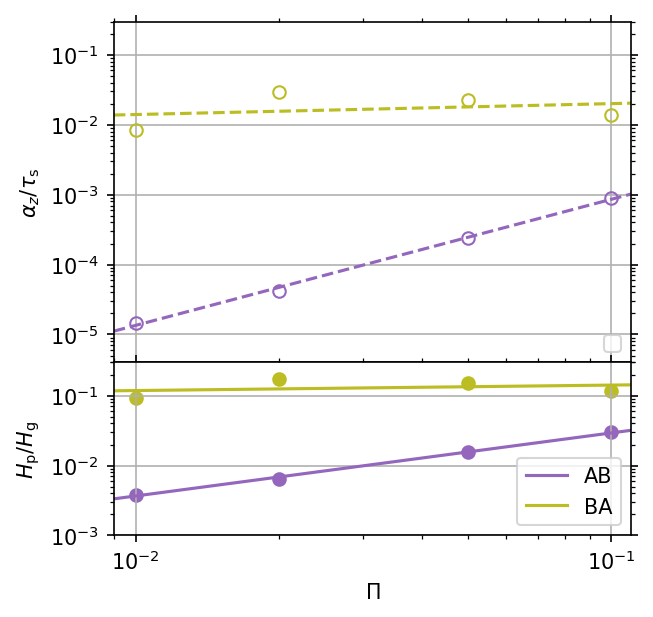

In [13]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

D_ylim, Hp_ylim = (4e-6, 3e-1), (1e-3, 3e-1)
D_ydiff = np.log10(D_ylim[1]) - np.log10(D_ylim[0])
Hp_ydiff = np.log10(Hp_ylim[1]) - np.log10(Hp_ylim[0])
h_ratio = D_ydiff/Hp_ydiff
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.45, 4.45), dpi=150,
                        height_ratios=[h_ratio, 1])
workdir = '../unstrat'
cases = [['AB', 'tab:purple', 1.0], ['BA', 'tab:olive', 0.2]]
Pis = [0.01, 0.02, 0.05, 0.1]
res = '2048'
dirs = [['x', 'dpx', 'full', 'solid'],
        ['z', 'dpy', 'none', 'dashed']]
pow_law = lambda Pi, a, k : a*Pi**k
lin_fit = lambda x, b, m : m*x + b
xs = np.linspace(0.009, 0.2)

# Diffusion coefficient variables
Ds = np.zeros((len(Pis), len(dirs)))
logDs = np.zeros((len(Pis), len(dirs)))
D_runs, tdirs = [], []
D_as, D_a_ferrs = [], []
D_ks, D_k_ferrs = [], []

# Particle scale height variables
Hps = np.zeros(len(Pis))
logHps = np.zeros(len(Pis))
Hp = lambda Dz, tau_s: np.sqrt(Dz*(tau_s + 1/tau_s))
Hp_cases = []
Hp_as, Hp_a_ferrs = [], []
Hp_ks, Hp_k_ferrs = [], []

for case in cases:
    axs[1].plot([], [], color=case[1], label=case[0])

    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            # Collect sim parameters, diffusion coefficients, dust scale heights
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            c_s = athinput['hydro']['iso_sound_speed']
            Omega = athinput['problem']['omega']
            Hg = c_s/Omega
            tau_s = athinput['particles']['taus0']*Omega
            npz = np.load(f'{path}/npz/dcoeff.npz')
            Ds[j, i] = npz[dir[1]][0]/c_s                 # convert to [c_s*Hg]
            logDs[j, i] = np.log(Ds[j, i])
            if dir[0] == 'z':
                Hps[j] = Hp(Ds[j, i], tau_s)
                logHps[j] = np.log(Hps[j])
                if Pi == 0.05:
                    print(f'{case[0]} (Π = 0.05):')
                    print(f'    Hp = {Hps[j]:.3f}Hg')
                    print(f'  Zeff = {case[2]*Hps[j]:.3f}')

        # Fit and plot alpha_z
        alpha_z_Sts = Ds*(1 + tau_s**2)/tau_s
        log_alpha_z_Sts = np.log(alpha_z_Sts)
        popt, pcov = curve_fit(lin_fit, np.log(Pis), log_alpha_z_Sts[:, i])
        perr = np.sqrt(np.diag(pcov))
        a, k = np.exp(popt[0]), popt[1]
        a_err, k_err = perr[0], perr[1]
        sigma = np.exp(perr[0])
        fit_high = pow_law(xs, a*sigma, k - k_err)
        fit_low = pow_law(xs, a/sigma, k + k_err)
        if dir[0] == 'z':
            axs[0].plot(Pis, alpha_z_Sts[:, i], marker='o', ls='none', color=case[1],
                        fillstyle=dir[2])
            axs[0].plot(xs, pow_law(xs, a, k), ls=dir[3], color=case[1])
        # axs[0].fill_between(xs, fit_high, fit_low, color=case[1], ec=None,
        #                     alpha=0.2)
        # D_runs.append(case[0]); tdirs.append(dir[0])
        # D_as.append(a); D_a_ferrs.append(a_err)
        # D_ks.append(k); D_k_ferrs.append(k_err/k)

    # Plot D_scale
    # Dscale = pow_law(xs, 1, 2) / (1 + tau_s**2)
    # axs[0].plot(xs, Dscale, ls=':', color=case[1])# = 2\pi\Pi^2$')

    # Plot dust scale heights
    popt, pcov = curve_fit(lin_fit, np.log(Pis), logHps)
    perr = np.sqrt(np.diag(pcov))
    a, k = np.exp(popt[0]), popt[1]
    a_err, k_err = perr[0], perr[1]
    sigma = np.exp(perr[0])
    fit_high = pow_law(xs, a*sigma, k - k_err)
    fit_low = pow_law(xs, a/sigma, k + k_err)
    axs[1].scatter(Pis, Hps, color=case[1])
    axs[1].plot(xs, pow_law(xs, a, k), color=case[1])
    # axs[1].fill_between(xs, fit_high, fit_low, color=case[1], ec=None, alpha=0.2)
    Hp_cases.append(case[0])
    Hp_as.append(a); Hp_a_ferrs.append(a_err)
    Hp_ks.append(k); Hp_k_ferrs.append(k_err/k)

# Plot line style ghost points; format plots and legend
# axs[0].plot([], [], color='tab:gray', label='$D_{\mathrm{p},x}$', marker='o')
# axs[0].plot([], [], color='tab:gray', ls='--', label='$D_{\mathrm{p},z}$', marker='o',
#             fillstyle='none')
# axs[0].plot([], [], color='tab:gray', ls=':', label=r'$D_\mathrm{p,scale}$')
axs[0].set(ylabel=r'$\alpha_z / \tau_\mathrm{s}$', ylim=D_ylim)
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$H_\mathrm{p}/H_\mathrm{g}$',
           xlim=(0.009, 0.11), ylim=Hp_ylim)

for ax in axs.flat:
    ax.grid()
    ax.legend(loc='lower right')
    ax.set(xscale='log', yscale='log')
    ax.tick_params(which='both', top=True, right=True)

fig.subplots_adjust(hspace=0)
plt.savefig('figs/alpha_z.pdf', bbox_inches='tight', pad_inches=0.01)

df1 = pd.DataFrame({
    'Case'   : D_runs,
    'Dir'    : tdirs,
    'a'      : D_as,
    'a_f.e.' : D_a_ferrs,
    'k'      : D_ks,
    'k_f.e.' : D_k_ferrs,})
s1 = df1.style.format({
    'a'      : '{:.3e}',
    'a_f.e.' : '± {:.0%}',
    'k'      : '{:.3f}',
    'k_f.e.' : '± {:.0%}',})

df2 = pd.DataFrame({
    'Case'   : Hp_cases,
    'a'      : Hp_as,
    'a_f.e.' : Hp_a_ferrs,
    'k'      : Hp_ks,
    'k_f.e.' : Hp_k_ferrs,})
s2 = df2.style.format({
    'a'      : '{:.3f}',
    'a_f.e.' : '± {:.0%}',
    'k'      : '{:.3f}',
    'k_f.e.' : '± {:.0%}',})

# s1
s2

## Uncertainty
- The time interval over which the diffusion coefficient $D = \sigma^2/\Delta t$ is calculated must be much greater than the characteristic correlation time, i.e., $\Delta t \gg t_\mathrm{corr}$
  - See [Yang, Mac Low & Johansen (2018, $\S$ 3.2)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868...27Y/abstract) and [Johansen & Youdin (2007, $\S$ 4.3)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868...27Y/abstract) for the definition of $t_\mathrm{corr}$ and associated computational proceedures.
  - As a rule-of-thumb lower limit, $\Delta t \gg T$.
  - The intervals $\Delta t$ can overlap, i.e., $\Delta t_1 = 10T - 0T$, $\Delta t_1 = 15T - 5T$, $\Delta t_1 = 20T - 10T$, etc.
- As a validity check, plotting $D$ vs. $t$ should yield no long-term curvature or overall deviation from constantcy ([Johansen & Youdin 2007, $\S$ 5.3.1](https://ui.adsabs.harvard.edu/abs/2018ApJ...868...27Y/abstract)).

In [ ]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

D_ylim, Hp_ylim = (4e-7, 3e-2), (1e-3, 3e-1)
D_ydiff = np.log10(D_ylim[1]) - np.log10(D_ylim[0])
Hp_ydiff = np.log10(Hp_ylim[1]) - np.log10(Hp_ylim[0])
h_ratio = D_ydiff/Hp_ydiff
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.45, 4.45), dpi=150,
                        height_ratios=[h_ratio, 1])
workdir = '../unstrat'
cases = [['AB', 'tab:purple'], ['BA', 'tab:olive']]
Pis = [0.01, 0.02, 0.05, 0.1]
res = '2048'
dirs = [['x', 'dpx', 'full', 'solid'],
        ['z', 'dpy', 'none', 'dashed']]
pow_law = lambda Pi, a, k : a*Pi**k
lin_fit = lambda x, b, m : m*x + b
xs = np.linspace(0.009, 0.2)

# Diffusion coefficient variables
Ds = np.zeros((len(Pis), len(dirs)))
logDs = np.zeros((len(Pis), len(dirs)))
D_runs, tdirs = [], []
D_as, D_a_ferrs = [], []
D_ks, D_k_ferrs = [], []

# Particle scale height variables
Hps = np.zeros(len(Pis))
logHps = np.zeros(len(Pis))
Hp = lambda Dz, tau_s: np.sqrt(Dz*(tau_s + 1/tau_s))
Hp_cases = []
Hp_as, Hp_a_ferrs = [], []
Hp_ks, Hp_k_ferrs = [], []

for case in cases:
    axs[1].plot([], [], color=case[1], label=case[0])

    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            # Collect sim parameters, diffusion coefficients, dust scale heights
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            c_s = athinput['hydro']['iso_sound_speed']
            Omega = athinput['problem']['omega']
            Hg = c_s/Omega
            tau_s = athinput['particles']['taus0']*Omega
            npz = np.load(f'{path}/npz/dcoeff_timevar.npz')
            """
            Revise below; follow GasTurbulence.ipynb
            """
            Ds[j, i] = npz[dir[1]][0]/c_s                 # convert to [c_s*Hg]
            logDs[j, i] = np.log(Ds[j, i])
            if dir[0] == 'z':
                Hps[j] = Hp(Ds[j, i], tau_s)
                logHps[j] = np.log(Hps[j])


        # Fit and plot diffusion coefficients
        popt, pcov = curve_fit(lin_fit, np.log(Pis), logDs[:, i])
        perr = np.sqrt(np.diag(pcov))
        a, k = np.exp(popt[0]), popt[1]
        a_err, k_err = perr[0], perr[1]
        sigma = np.exp(perr[0])
        fit_high = pow_law(xs, a*sigma, k - k_err)
        fit_low = pow_law(xs, a/sigma, k + k_err)
        axs[0].plot(Pis, Ds[:, i], marker='o', ls='none', color=case[1],
                    fillstyle=dir[2])
        axs[0].plot(xs, pow_law(xs, a, k), ls=dir[3], color=case[1])
        # axs[0].fill_between(xs, fit_high, fit_low, color=case[1], ec=None,
        #                     alpha=0.2)
        D_runs.append(case[0]); tdirs.append(dir[0])
        D_as.append(a); D_a_ferrs.append(a_err)
        D_ks.append(k); D_k_ferrs.append(k_err/k)

    # Plot dust scale heights
    popt, pcov = curve_fit(lin_fit, np.log(Pis), logHps)
    perr = np.sqrt(np.diag(pcov))
    a, k = np.exp(popt[0]), popt[1]
    a_err, k_err = perr[0], perr[1]
    sigma = np.exp(perr[0])
    fit_high = pow_law(xs, a*sigma, k - k_err)
    fit_low = pow_law(xs, a/sigma, k + k_err)
    axs[1].scatter(Pis, Hps, color=case[1])
    axs[1].plot(xs, pow_law(xs, a, k), color=case[1])
    # axs[1].fill_between(xs, fit_high, fit_low, color=case[1], ec=None, alpha=0.2)
    Hp_cases.append(case[0])
    Hp_as.append(a); Hp_a_ferrs.append(a_err)
    Hp_ks.append(k); Hp_k_ferrs.append(k_err/k)

# Plot line style ghost points, Dscale; format plots and legend
axs[0].plot([], [], color='tab:gray', label='$D_x$', marker='o')
axs[0].plot([], [], color='tab:gray', ls='--', label='$D_z$', marker='o',
            fillstyle='none')
axs[0].plot(xs, pow_law(xs, 1, 2), ls=':', color='black',
            label=r'$D_\mathrm{scale}$')# = 2\pi\Pi^2$')
axs[0].set(ylabel=r'$D_{x,z}/c_\mathrm{s}H_\mathrm{g}$', ylim=D_ylim)
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$H_\mathrm{p}/H_\mathrm{g}$',
           xlim=(0.009, 0.11), ylim=Hp_ylim)

for ax in axs.flat:
    ax.grid()
    ax.legend(loc='lower right')
    ax.set(xscale='log', yscale='log')
    ax.tick_params(which='both', top=True, right=True)

fig.subplots_adjust(hspace=0)
plt.savefig('figs/diffusion.pdf', bbox_inches='tight', pad_inches=0.01)

df1 = pd.DataFrame({
    'Case'   : D_runs,
    'Dir'    : tdirs,
    'a'      : D_as,
    'a_f.e.' : D_a_ferrs,
    'k'      : D_ks,
    'k_f.e.' : D_k_ferrs,})
s1 = df1.style.format({
    'a'      : '{:.2e}',
    'a_f.e.' : '± {:.0%}',
    'k'      : '{:.2f}',
    'k_f.e.' : '± {:.0%}',})

df2 = pd.DataFrame({
    'Case'   : Hp_cases,
    'a'      : Hp_as,
    'a_f.e.' : Hp_a_ferrs,
    'k'      : Hp_ks,
    'k_f.e.' : Hp_k_ferrs,})
s2 = df2.style.format({
    'a'      : '{:.2f}',
    'a_f.e.' : '± {:.0%}',
    'k'      : '{:.2f}',
    'k_f.e.' : '± {:.0%}',})

s1
# s2